In [93]:
import pandas as pd
import numpy as np
import seaborn as sns
import requests
import pandas as pd
from pandas_datareader import data
import matplotlib.pyplot as plt

sns.set(style='darkgrid', context='talk', palette='Dark2')

Having imported the appropriate tools, getting market data from a free online source, such as Yahoo Finance, is super easy. Since pandas has a simple remote data access for the Yahoo Finance API data, this is as simple as:

In [94]:
# Define the instruments to download. We would like to see Apple, Microsoft and the S&P500 index.
tickers = ['AAPL', 'MSFT', 'GOOG']

# We would like all available data from 01/01/2000 until 12/31/2016.
start_date = '2010-01-01'
end_date = '2022-10-31'

# User pandas_reader.data.DataReader to load the desired data.
df = data.DataReader(tickers, 'yahoo', start_date, end_date)
df

Attributes   Adj Close                               Close              \
Symbols           AAPL        MSFT        GOOG        AAPL        MSFT   
Date                                                                     
2010-01-04    6.526021   23.749815   15.610239    7.643214   30.950001   
2010-01-05    6.537303   23.757484   15.541497    7.656429   30.959999   
2010-01-06    6.433318   23.611692   15.149715    7.534643   30.770000   
2010-01-07    6.421425   23.366131   14.797037    7.520714   30.450001   
2010-01-08    6.464118   23.527275   14.994298    7.570714   30.660000   
...                ...         ...         ...         ...         ...   
2022-10-24  149.449997  247.250000  102.970001  149.449997  247.250000   
2022-10-25  152.339996  250.660004  104.930000  152.339996  250.660004   
2022-10-26  149.350006  231.320007   94.820000  149.350006  231.320007   
2022-10-27  144.800003  226.750000   92.599998  144.800003  226.750000   
2022-10-28  155.740005  235.869995   96.580002  155.740005  235.869995   

Attributes                    High                                 Low  \
Symbols           GOOG        AAPL        MSFT        GOOG        AAPL   
Date                                                                     
2010-01-04   15.610239    7.660714   31.100000   15.678981    7.585000   
2010-01-05   15.541497    7.699643   31.100000   15.637387    7.616071   
2010-01-06   15.149715    7.686786   31.080000   15.588072    7.526786   
2010-01-07   14.797037    7.571429   30.700001   15.193053    7.466071   
2010-01-08   14.994298    7.571429   30.879999   15.024933    7.466429   
...                ...         ...         ...         ...         ...   
2022-10-24  102.970001  150.229996  247.839996  103.099998  146.000000   
2022-10-25  104.930000  152.490005  251.039993  105.099998  149.360001   
2022-10-26   94.820000  151.990005  238.300003   98.540001  148.039993   
2022-10-27   92.599998  149.050003  233.690002   95.169998  144.130005   
2022-10-28   96.580002  157.500000  236.600006   96.860001  147.820007   

Attributes                                Open                          \
Symbols           MSFT        GOOG        AAPL        MSFT        GOOG   
Date                                                                     
2010-01-04   30.590000   15.547723    7.622500   30.620001   15.615220   
2010-01-05   30.639999   15.480475    7.664286   30.850000   15.620949   
2010-01-06   30.520000   15.102393    7.656429   30.879999   15.588072   
2010-01-07   30.190001   14.760922    7.562500   30.629999   15.178109   
2010-01-08   30.240000   14.672753    7.510714   30.280001   14.744733   
...                ...         ...         ...         ...         ...   
2022-10-24  241.300003  100.300003  147.190002  243.759995  102.089996   
2022-10-25  245.830002  103.019997  150.089996  247.259995  103.300003   
2022-10-26  230.059998   94.570000  150.960007  231.169998   96.760002   
2022-10-27  225.779999   91.900002  148.070007  231.039993   94.309998   
2022-10-28  226.050003   92.322998  148.199997  226.240005   92.529999   

Attributes       Volume                           
Symbols            AAPL        MSFT         GOOG  
Date                                              
2010-01-04  493729600.0  38409100.0   78541293.0  
2010-01-05  601904800.0  49749600.0  120638494.0  
2010-01-06  552160000.0  58182400.0  159744526.0  
2010-01-07  477131200.0  50559700.0  257533695.0  
2010-01-08  447610800.0  51197400.0  189680313.0  
...                 ...         ...          ...  
2022-10-24   75981900.0  24911200.0   24680800.0  
2022-10-25   74732300.0  34775500.0   29910200.0  
2022-10-26   88194300.0  82543200.0   71504300.0  
2022-10-27  109180200.0  40424600.0   54036500.0  
2022-10-28  164659100.0  40614800.0   35666500.0  

[3229 rows x 18 columns]

In [95]:
tesla = data.DataReader('TSLA', 'yahoo', start_date, end_date)
tesla

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2010-06-29,1.666667,1.169333,1.266667,1.592667,281494500.0,1.592667
2010-06-30,2.028000,1.553333,1.719333,1.588667,257806500.0,1.588667
2010-07-01,1.728000,1.351333,1.666667,1.464000,123282000.0,1.464000
2010-07-02,1.540000,1.247333,1.533333,1.280000,77097000.0,1.280000
2010-07-06,1.333333,1.055333,1.333333,1.074000,103003500.0,1.074000
...,...,...,...,...,...,...
2022-10-24,213.500000,198.589996,205.820007,211.250000,100446800.0,211.250000
2022-10-25,224.350006,210.000000,210.100006,222.419998,96507900.0,222.419998
2022-10-26,230.600006,218.199997,219.399994,224.639999,85012500.0,224.639999


#### Preparing the Data

Let us assume we are interested in working with the Close prices which have been already been adjusted by Yahoo finance to account for stock splits. We want to make sure that all weekdays are included in our dataset, which is very often desirable for quantitative trading strategies.

Of course, some of the weekdays might be public holidays in which case no price will be available. For this reason, we will fill the missing prices with the latest available prices:

In [96]:
# Getting just the adjusted closing prices. This will return a Pandas DataFrame
# The index in this DataFrame is the major index of the data frame.
close = df['Close']
volume = df['Volume']

# Getting all weekdays between 01/01/2000 and 12/31/2016  https://pandas.pydata.org/docs/user_guide/timeseries.html#timeseries-offset-aliases
all_weekdays = pd.date_range(start=start_date, end=end_date, freq='B')  # B stands for business day frequency

# How do we align the existing prices in adj_close with our new set of dates?
# All we need to do is reindex close using all_weekdays as the new index     https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.reindex.html
close = close.reindex(all_weekdays)
volume = volume.reindex(all_weekdays)

# Reindexing will insert missing values (NaN) for the dates that were not present
# in the original set. To cope with this, we can fill the missing by replacing them
# with the latest available price for each instrument.  https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.fillna.html
close = close.fillna(method='ffill')
volume = volume.fillna(method='ffill')


In [97]:
close.to_csv(index = False)    # https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.to_csv.html
pass

In [98]:
print(all_weekdays)

DatetimeIndex(['2010-01-01', '2010-01-04', '2010-01-05', '2010-01-06',
               '2010-01-07', '2010-01-08', '2010-01-11', '2010-01-12',
               '2010-01-13', '2010-01-14',
               ...
               '2022-10-18', '2022-10-19', '2022-10-20', '2022-10-21',
               '2022-10-24', '2022-10-25', '2022-10-26', '2022-10-27',
               '2022-10-28', '2022-10-31'],
              dtype='datetime64[ns]', length=3347, freq='B')


In [99]:
close.describe()

Symbols,AAPL,MSFT,GOOG
count,3346.000000,3346.000000,3346.000000
mean,50.106480,98.198933,48.376583
std,46.479874,87.258404,36.007256
min,6.858929,23.010000,10.861040
25%,18.934107,31.620001,19.934780
50%,29.492500,54.949999,37.243000
75%,55.203126,137.254997,60.498125
max,182.009995,343.109985,150.709000


In [100]:
volume.describe()

Symbols,AAPL,MSFT,GOOG
count,3.346000e+03,3.346000e+03,3.346000e+03
mean,2.575186e+08,3.795518e+07,5.792612e+07
std,2.226907e+08,2.142994e+07,5.043911e+07
min,4.100000e+07,7.425600e+06,1.584340e+05
25%,1.032846e+08,2.370880e+07,2.613200e+07
50%,1.679694e+08,3.227460e+07,3.765756e+07
75%,3.472406e+08,4.687370e+07,7.864970e+07
max,1.880998e+09,3.193179e+08,5.952147e+08


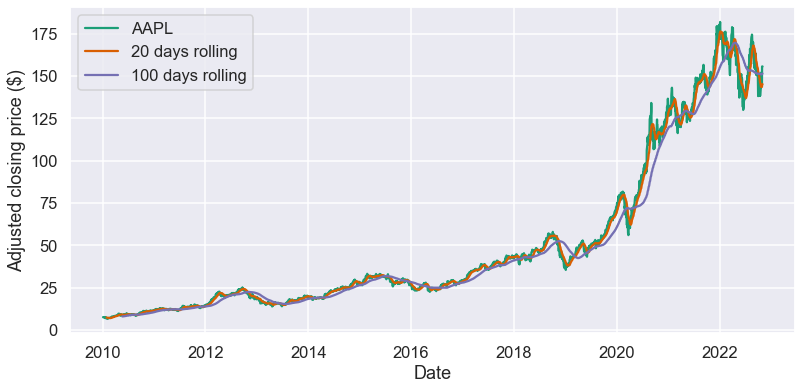

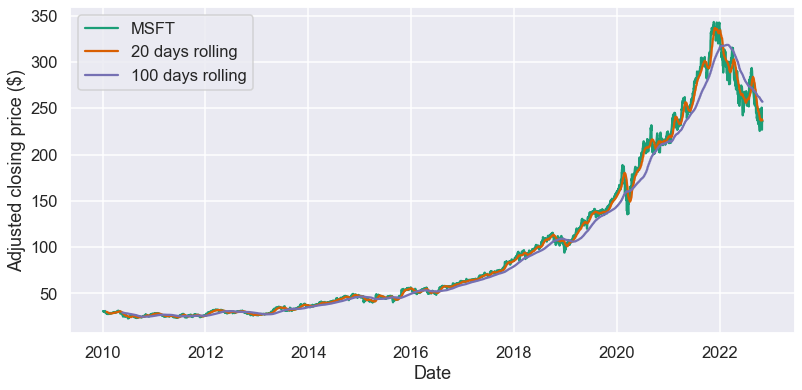

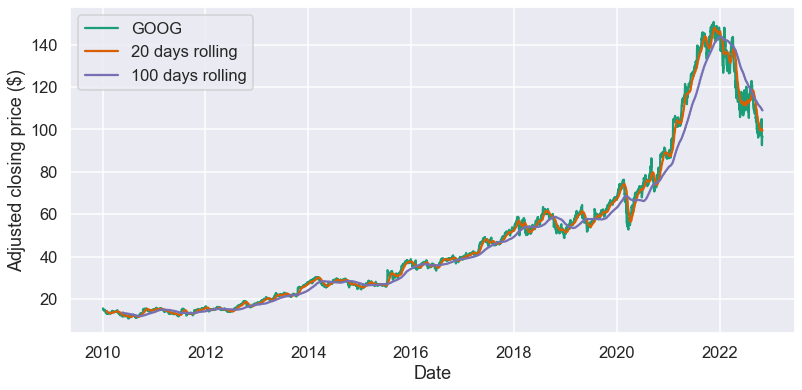

In [101]:
for i in tickers:
    # Get the ticker timeseries. This now returns a Pandas Series object indexed by date.
    ticker = close.loc[:, i]

    # Calculate the 20 and 100 days moving averages of the closing prices
    short_rolling_ticker = ticker.rolling(window=20).mean()
    long_rolling_ticker = ticker.rolling(window=100).mean()

    # Plot everything by leveraging the very powerful matplotlib package
    fig, ax = plt.subplots(figsize=(13,6))

    ax.plot(ticker.index, ticker, label=i)
    ax.plot(short_rolling_ticker.index, short_rolling_ticker, label='20 days rolling')
    ax.plot(long_rolling_ticker.index, long_rolling_ticker, label='100 days rolling')

    ax.set_xlabel('Date')
    ax.set_ylabel('Adjusted closing price ($)')
    ax.legend()


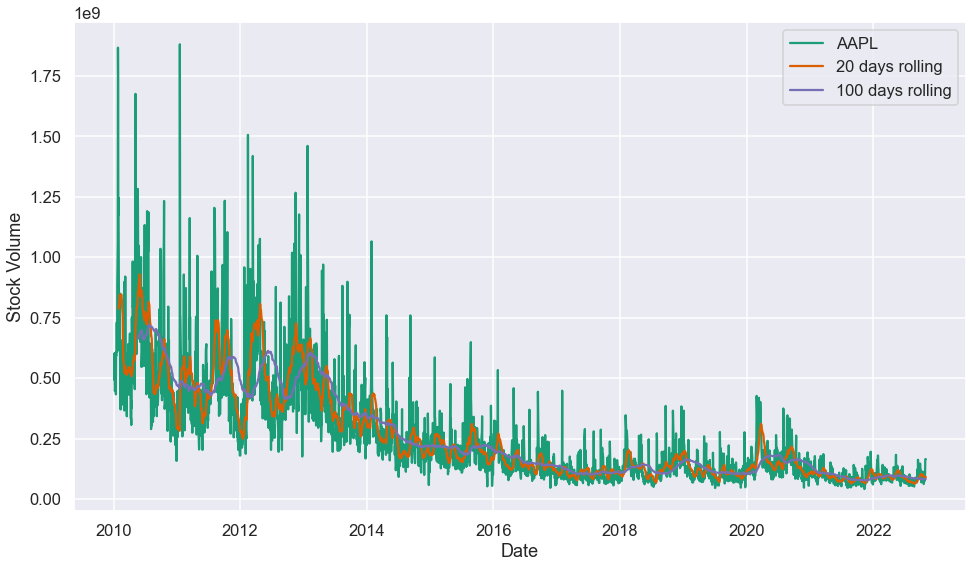

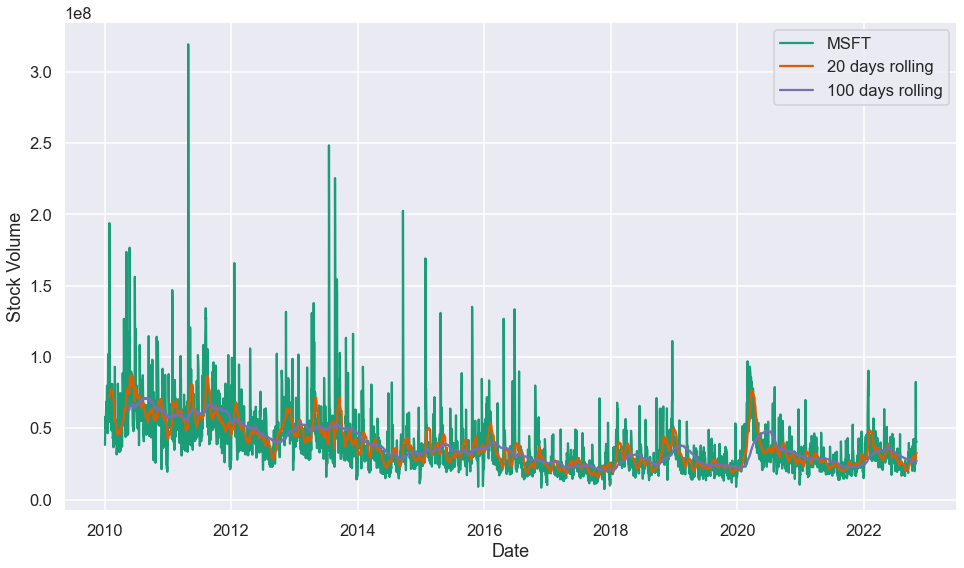

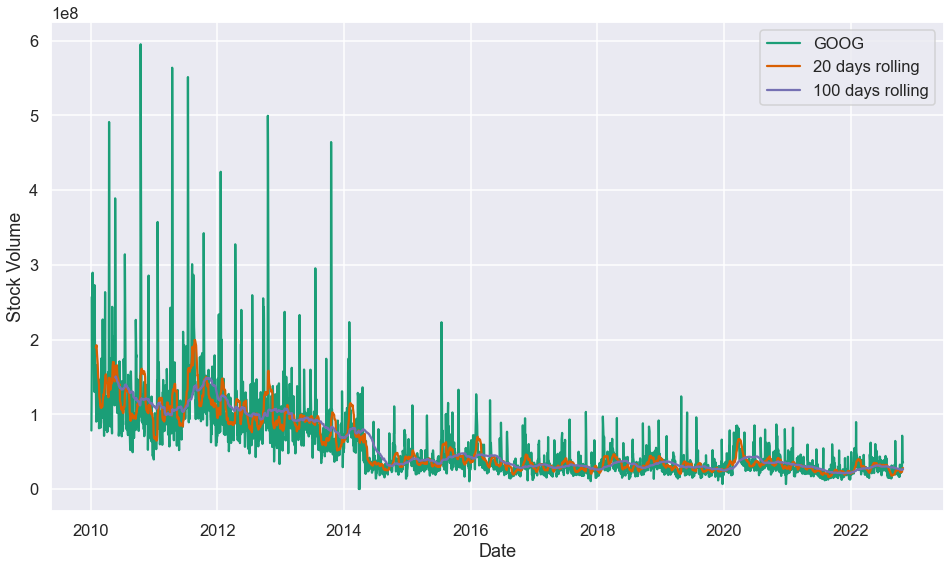

In [103]:
for i in tickers:
    # Get the ticker timeseries. This now returns a Pandas Series object indexed by date.
    ticker = volume.loc[:, i]

    # Calculate the 20 and 100 days moving averages of the closing prices
    short_rolling_ticker = ticker.rolling(window=20).mean()
    long_rolling_ticker = ticker.rolling(window=100).mean()

    # Plot everything by leveraging the very powerful matplotlib package
    fig, ax = plt.subplots(figsize=(16,9))

    ax.plot(ticker.index, ticker, label=i)
    ax.plot(short_rolling_ticker.index, short_rolling_ticker, label='20 days rolling')
    ax.plot(long_rolling_ticker.index, long_rolling_ticker, label='100 days rolling')

    ax.set_xlabel('Date')
    ax.set_ylabel('Stock Volume')
    ax.legend()
